In [9]:
import sqlite3
import numpy as np

In [2]:
dim = 32
dir = 'itwac'

sql_path = f'{dir}/itwac{dim}.sqlite'
txt_path = f'{dir}/itwac{dim}.txt'

In [3]:
con = sqlite3.connect(sql_path)

In [4]:
cur = con.cursor()

In [5]:
with open(txt_path, 'w+') as out_file:
    for embedding in cur.execute("SELECT * FROM store"):
        str_embedding = [str(el) for el in embedding[:-1]]
        out_file.write('\t'.join(str_embedding)+'\n')

out_file.close()

In [6]:
embeddings_dim = 32
embeddings_path = f'itwac/itwac{embeddings_dim}.txt'

In [7]:
def load_word_embeddings(src_path):
    embeddings = dict()
    for line in open(src_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [10]:
embeddings = load_word_embeddings(embeddings_path)


In [21]:
embeddings['veder-']

array([ 0.00693607, -0.13223223,  0.17766103, -0.1846723 ,  0.10832494,
       -0.16631842,  0.1188259 , -0.19742745, -0.09738307,  0.05717961,
       -0.03427332,  0.03524074, -0.05007853,  0.12838058, -0.41803515,
        0.02980422,  0.02071255, -0.13293201,  0.04718199, -0.08186675,
        0.2480845 ,  0.08449214, -0.35181698,  0.11689875, -0.06619578,
        0.27993774, -0.26592675,  0.24080883, -0.01441755,  0.23544694,
        0.03297047,  0.33640549])

In [22]:
min_value = 99999
max_value = -99999
for word in embeddings:
    for comp in embeddings[word]:
        if comp > max_value:
            max_value = comp
        elif comp < min_value:
            min_value = comp

print(f'Valore minimo = {min_value}')
print(f'Valore massimo = {max_value}')

Valore minimo = -0.7974681258201599
Valore massimo = 0.7941803336143494


In [23]:
words = ['mela', 'pera', 'banana', 'arancia', 'kiwi', 'mandarino', 'automobile', 'camion', 'pullman', 'moto', 'bici', 'autobus']

embs = [embeddings[word] for word in words] 
embs = np.stack(embs, axis=0) # la funzione stack "attacca" una lista di vettori, creando una matrice

In [24]:
embs.shape


(12, 32)

In [32]:
from sklearn.manifold import TSNE
reduced_embs = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embs)

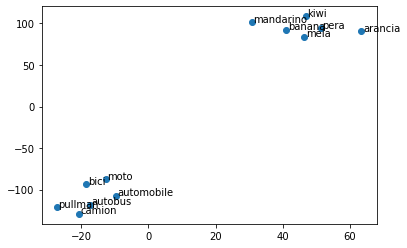

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(reduced_embs[:,0], reduced_embs[:,1])
for i, word in enumerate(words):
    ax.annotate(word, (reduced_embs[i,0]+0.5, reduced_embs[i, 1]+0.5))

In [34]:
conllu_dir = 'profiling_output/11152'

In [36]:
import os
all_documents_paths = []
for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    all_documents_paths.append(file_path)


In [37]:
import re

def get_digits(text):
    try:
      val = int(text)
    except:
      text = re.sub('\d', '@Dg', text)
      return text
    if val >= 0 and val < 2100:
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val)))

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

In [38]:
def get_tokens_from_file(src_path):
    document_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r'):
        # print(f'\nRiga: {line.strip()}')
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                # print('Ho trovato un - ')
                skip_ids = splitted_line[0].split('-')
                # print('Indici da saltare', skip_ids)
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # booleano che indica che dobbiamo prendere la pos della prossima parola
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = {
                    'word': word,
                    'pos': '_'
                }
                # print(f'Preso token {word}')
                document_tokens.append(token)
            else:
                if lines_to_skip == 0:
                    
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    # print(f'Preso token {word}')
                    document_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    document_tokens[-1]['pos'] = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return document_tokens

In [39]:
all_documents = []

for document_path in all_documents_paths:
    document_tokens = get_tokens_from_file(document_path)
    all_documents.append(document_tokens)

In [43]:
all_documents[0][:20]


[{'word': '"', 'pos': 'PUNCT'},
 {'word': 'Gay', 'pos': 'PROPN'},
 {'word': 'Pride', 'pos': 'PROPN'},
 {'word': '?', 'pos': 'PUNCT'},
 {'word': 'Solo', 'pos': 'ADV'},
 {'word': 'folklore', 'pos': 'NOUN'},
 {'word': '"', 'pos': 'PUNCT'},
 {'word': '.', 'pos': 'PUNCT'},
 {'word': 'A', 'pos': 'ADP'},
 {'word': 'Novara', 'pos': 'PROPN'},
 {'word': 'il', 'pos': 'DET'},
 {'word': 'sindaco', 'pos': 'NOUN'},
 {'word': 'leghista', 'pos': 'ADJ'},
 {'word': 'nega', 'pos': 'VERB'},
 {'word': 'il', 'pos': 'DET'},
 {'word': 'patrocinio', 'pos': 'NOUN'},
 {'word': 'ed', 'pos': 'CCONJ'},
 {'word': 'è', 'pos': 'AUX'},
 {'word': 'polemica', 'pos': 'NOUN'},
 {'word': '"', 'pos': 'PUNCT'}]

In [48]:
def compute_embeddings_mean(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(document_embeddings))
    return mean_array

In [50]:
def compute_filtered_embeddings_mean(document_tokens):
    document_embeddings = []
    
    for token in document_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB']:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

In [51]:
def extract_features(documents):
    dataset_features = []
    for document_tokens in documents:
        # document_embeddings = compute_all_embeddings_mean(document_tokens)
        document_embeddings = compute_filtered_embeddings_mean(document_tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document_tokens)
        dataset_features.append(document_embeddings)
    return dataset_features

In [53]:
all_features = extract_features(all_documents)


In [54]:
len(all_features), len(all_features[0])


(400, 32)

In [55]:
def create_label_list(all_documents_paths):
    labels = []
    for document_path in all_documents_paths:
        document_path = document_path[:-len('.conllu')]
        splitted_file_path = document_path.split('#')
        genre = splitted_file_path[2]
        gender = splitted_file_path[3]
        labels.append(gender)
    return labels

In [56]:
all_labels = create_label_list(all_documents_paths)


In [57]:
all_labels[:10]


['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M']

In [58]:
def train_test_split(all_features, all_labels, all_documents_paths):
    train_features, train_labels = [], []
    test_features, test_labels = [], []
    
    for features, label,  document_path in zip(all_features, all_labels, all_documents_paths):
        if 'training' in document_path:
            train_features.append(features)
            train_labels.append(label)
        else:
            test_features.append(features)
            test_labels.append(label)
    return train_features, train_labels, test_features, test_labels


In [59]:
train_features, train_labels, test_features, test_labels = train_test_split(all_features, all_labels, all_documents_paths)
len(train_features), len(train_labels), len(test_features), len(test_labels)

(200, 200, 200, 200)

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# X_train = np.stack(train_features, axis=0)
X_train = scaler.fit_transform(train_features)

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the parameter grid to search through
param_grid = {
    'C': [0.1, 0.01, 0.001, 0.0001],  # Regularization parameter
    'dual': [True, False]
}

# Initialize SVM with linear kernel
svc = LinearSVC()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X_train, train_labels)

# Get mean test scores across folds
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)

Best parameters found: {'C': 0.1, 'dual': True}
Best score found: 0.595


In [76]:
X_test = scaler.transform(test_features)
# Get the best estimator (model) found by grid search
best_model = grid_search.best_estimator_

# Now, you can use this best_model to make predictions on new data
# For example, if you have new data X_new, you can predict its labels as follows:
predictions = best_model.predict(X_test)

In [77]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
test_predictions = predictions
print(classification_report(test_labels, test_predictions, zero_division=0)) # output_dict=True

              precision    recall  f1-score   support

           F       0.47      0.58      0.52       100
           M       0.45      0.35      0.40       100

    accuracy                           0.47       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.47      0.46       200

